In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/hate-speech-and-offensive-language-dataset/labeled_data.csv


In [3]:
#importing required libraries

import re
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsOneClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, plot_confusion_matrix, classification_report,ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from wordcloud import WordCloud

In [4]:
#Reading the data set
df=pd.read_csv('/kaggle/input/hate-speech-and-offensive-language-dataset/labeled_data.csv')

In [5]:
df.head()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [6]:
df.shape

(24783, 7)

In [5]:
#independent feature
df_transformed=df[['class','tweet']]
#dependent feature
y = (df_transformed.iloc[:,:1].values).ravel()
df_transformed.shape

(24783, 2)

In [77]:
df_transformed

,class,tweet
0,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...
...,...,...
24778,1,you's a muthaf***in lie &#8220;@LifeAsKing: @2...
24779,2,"you've gone and broke the wrong heart baby, an..."
24780,1,young buck wanna eat!!.. dat nigguh like I ain...
24781,1,youu got wild bitches tellin you lies


In [25]:
y

array([2, 1, 1, ..., 1, 1, 2])

In [6]:
#Splitting the dataset into train and test data in 90:10 ratio 
df_train, df_test = train_test_split(df_transformed, test_size = 0.10, random_state = 42, stratify=df_transformed['class'])
df_train.shape, df_test.shape

((22304, 2), (2479, 2))

In [7]:
#Again splitting the training data to training and validatiopn data 
df_train, df_vad = train_test_split(df_train, test_size = 0.10, random_state = 42, stratify=df_train['class'])
df_train.shape, df_vad.shape

((20073, 2), (2231, 2))

# **TEXT PREPROCESSING**

In [8]:
def Preprocess(text):
    stemmer = nltk.stem.RSLPStemmer()
    stop_words=stopwords.words('english')
    stop_words.remove('not')
    corpus=[]
    for t in text:
        process_text=re.sub(r'@[A-Za-z0-9_]+',' ',t)
        process_text=re.sub('RT',' ',process_text)
        process_text=re.sub(r'https?://[A-Za-z0-9./]+',' ',process_text)
        process_text=re.sub(r"https?:",' ',process_text)
        process_text=re.sub('[^A-Za-z]',' ',process_text)
        process_text=process_text.lower()
        process_text=process_text.split()
        port_stem=PorterStemmer()
        process_text = [port_stem.stem(word) for word in process_text if not word  in set(stop_words) if len(word) > 2]
        process_text=' '.join(process_text)
        corpus.append(process_text)
    return np.array(corpus)

In [40]:
c_train=Preprocess(df_train['tweet'].values)

In [41]:
c_vad = Preprocess(df_vad['tweet'].values)

# **Extract features using tokenization**

In [15]:
tk=nltk.TweetTokenizer()
cv=CountVectorizer(analyzer="word",tokenizer=tk.tokenize, max_features = 1010)

In [16]:
X_train = cv.fit_transform(c_train).toarray()
X_vad = cv.transform(c_vad).toarray()
y_train = df_train['class'].values
y_vad = df_vad['class'].values
X_train.shape, X_vad.shape

((20073, 1010), (2231, 1010))

# **TRAINING LOGISTIC REGRESSION**

In [17]:
model=LogisticRegression(solver='liblinear',random_state=0)

In [18]:
ovo = OneVsOneClassifier(model)

In [19]:
ovo.fit(X_train, y_train.ravel())

OneVsOneClassifier(estimator=LogisticRegression(random_state=0,
                                                solver='liblinear'))

In [21]:
 y_pred=ovo.predict(X_vad)

In [22]:
y_pred

array([2, 1, 1, ..., 1, 2, 1])

In [23]:
cm=confusion_matrix(y_vad,y_pred)

Text(0.5, 1.0, 'LogisticRegression')

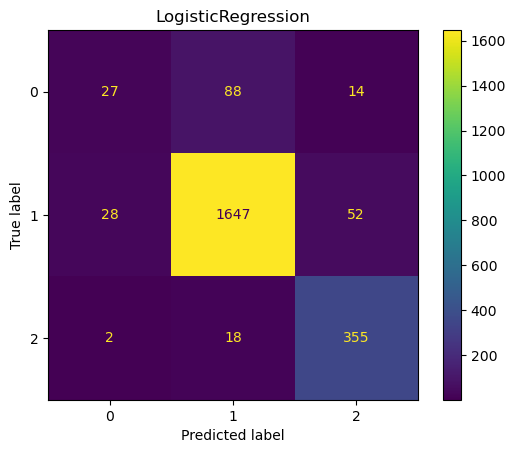

In [24]:
dis=ConfusionMatrixDisplay(cm)
dis.plot()
plt.title('LogisticRegression')

In [25]:
target_names = ['class 0', 'class 1', 'class 2']
print(classification_report(y_vad, y_pred, target_names=target_names))

              precision    recall  f1-score   support

     class 0       0.47      0.21      0.29       129
     class 1       0.94      0.95      0.95      1727
     class 2       0.84      0.95      0.89       375

    accuracy                           0.91      2231
   macro avg       0.75      0.70      0.71      2231
weighted avg       0.90      0.91      0.90      2231



In [26]:
c=c_train
hate_tweets = [sentence for sentence, label in zip(c, y) if label == 0]
offensive_tweets = [sentence for sentence, label in zip(c, y) if label == 1]
neither_tweets = [sentence for sentence, label in zip(c, y) if label == 2]

In [27]:
hate_tweets=' '.join(hate_tweets)
offensive_tweets=' '.join(offensive_tweets)
neither_tweets=' '.join(neither_tweets)

In [28]:
from nltk.tokenize import sent_tokenize,word_tokenize
sentences=sent_tokenize(hate_tweets)
words=word_tokenize(hate_tweets)

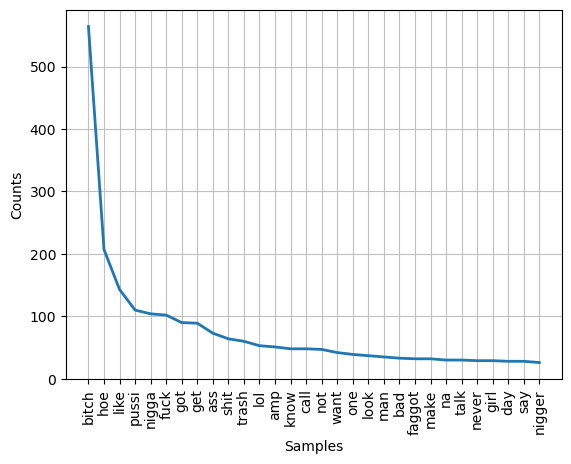

<AxesSubplot:xlabel='Samples', ylabel='Counts'>

In [35]:
import nltk
word_freq = nltk.FreqDist(words)
word_freq.plot(30)
#plt.figure()
 

# **WORD CLOUD CHART**

In [91]:
def word_cloud(tweet):
    wc=WordCloud().generate(tweet)
    plt.imshow(wc,interpolation='bilinear')
    plt.axis("off")
    plt.show()

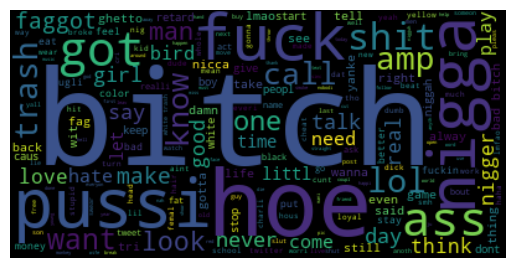

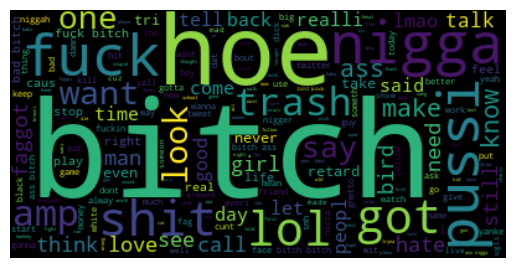

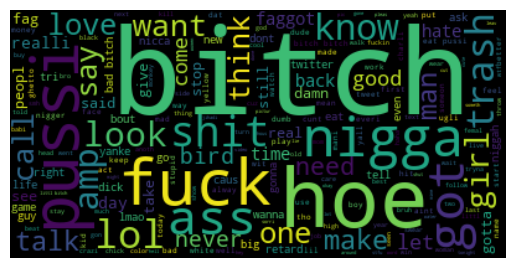

In [92]:
word_cloud(hate_tweets)
word_cloud(offensive_tweets)
word_cloud(neither_tweets)